In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

[(tmin, tavg, tmax)] = calc_temps('2017-08-01', '2017-08-07')

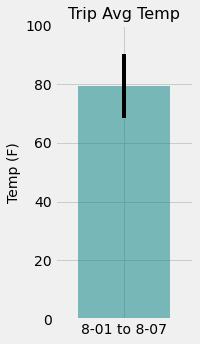

In [11]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(3,5))
plt.bar('8-01 to 8-07', tavg, yerr=tmax-tmin, color='teal', alpha=0.5)
plt.title("Trip Avg Temp", fontsize=16)
plt.ylabel("Temp (F)", fontsize=14)
plt.ylim(0, 100)
plt.xlim(-.6, .6)

plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [func.sum(Measurement.prcp), Measurement.station, 
       Station.name, Station.latitude, Station.longitude, Station.elevation]

results = session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.date >= '2017-08-01').filter(Measurement.date <= '2017-08-07').\
        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

pd.DataFrame(results, columns=['Total Precipitation', 'Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

,Total Precipitation,Station,Name,Latitude,Longitude,Elevation
0,0.36,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.22,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,0.06,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,0.04,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,0.00,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dates = []
date = start_date
while date <= end_date:
    dates.append(date)
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    date += dt.timedelta(days=1)
    date = dt.datetime.strftime(date, '%Y-%m-%d')
    
# Strip off the year and save a list of strings in the format %m-%d
trip_dates = [date[5:] for date in dates]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [list(daily_normals(date)[0]) for date in trip_dates]

# Adding trip dates column
for i in range(len(trip_dates)):
    normals[i].append(trip_dates[i])

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax', 'date'])
df.set_index('date', inplace=True)
df

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


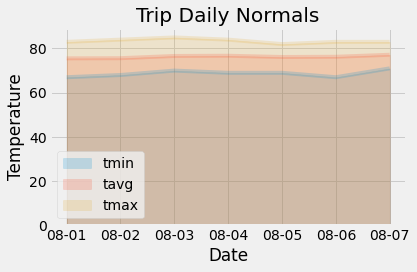

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, alpha=0.2)
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.title("Trip Daily Normals")

plt.tight_layout()
plt.show()

## Close Session

In [17]:
session.close()